In [1]:
!pip install -q tf-nightly

You should consider upgrading via the 'c:\users\jen\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
SEED = 1234
tf.random.set_seed(1234)

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)


train_dataset = image_dataset_from_directory('D:\Jen\Documents\Dissertation\Bee_Data_Split\Train',
                                             shuffle=True,
                                             seed=SEED,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory('D:\Jen\Documents\Dissertation\Bee_Data_Split\Test',
                                             shuffle=True,
                                             seed=SEED,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
class_names = train_dataset.class_names

Found 12311 files belonging to 19 classes.
Found 10427 files belonging to 19 classes.


Show the first nine images and labels from the training set:

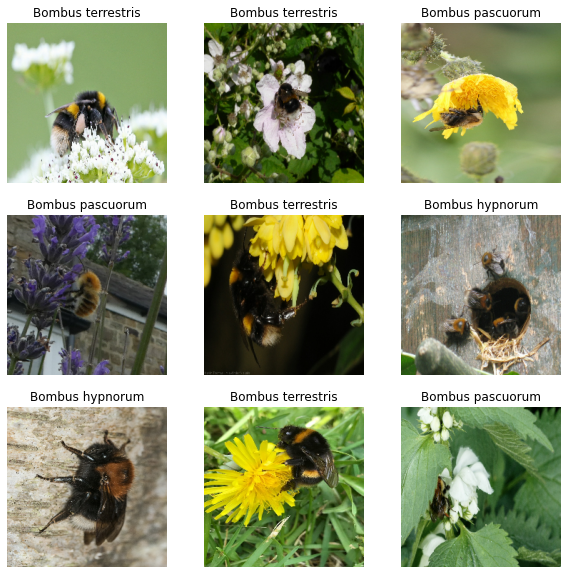

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [6]:
#val_batches = tf.data.experimental.cardinality(train_dataset)
#validation_dataset = train_dataset.take(val_batches // 2)
#train_dataset = train_dataset.skip(val_batches // 2)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 163
Number of test batches: 163


In [7]:
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
test_dataset = test_dataset.apply(tf.data.experimental.ignore_errors())
validation_dataset = validation_dataset.apply(tf.data.experimental.ignore_errors())

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

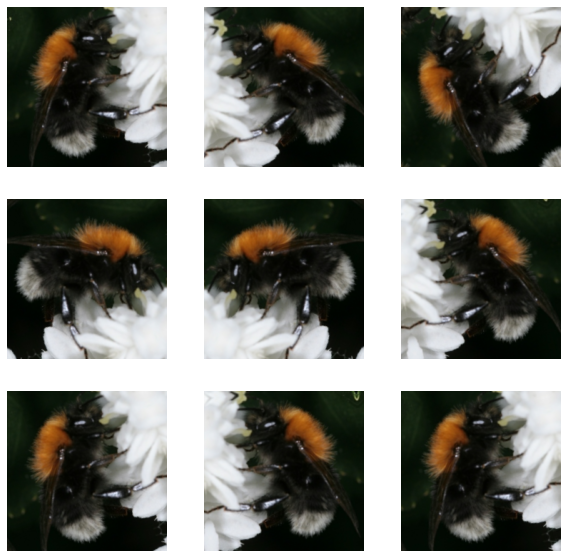

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [8]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet'
)

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [10]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [12]:
prediction_layer = tf.keras.layers.Dense(20, activation='softmax')
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [13]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2, seed=SEED)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                40980 

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [16]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [17]:
initial_epochs = 25

loss0, accuracy0, topk0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial top k: {:.2f}".format(topk0))

163/163 [==============================] - 497s 2s/step - loss: 4.2493 - sparse_categorical_accuracy: 0.0181 - sparse_top_k_categorical_accuracy: 0.0834
initial loss: 4.25
initial accuracy: 0.02
initial top k: 0.08


In [18]:
checkpoint_path = 'D:/Jen/Documents/Dissertation/Checkpoints/Split_25'
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, 
                    callbacks=[es_callback, cp_callback])

Epoch 1/25
385/385 [==============================] - 1371s 4s/step - loss: 2.6719 - sparse_categorical_accuracy: 0.2091 - sparse_top_k_categorical_accuracy: 0.4397 - val_loss: 1.9113 - val_sparse_categorical_accuracy: 0.4180 - val_sparse_top_k_categorical_accuracy: 0.6974

Epoch 00001: saving model to D:/Jen/Documents/Dissertation/Checkpoints\Split_25
Epoch 2/25
385/385 [==============================] - 1320s 3s/step - loss: 2.0866 - sparse_categorical_accuracy: 0.3602 - sparse_top_k_categorical_accuracy: 0.6226 - val_loss: 1.6404 - val_sparse_categorical_accuracy: 0.5145 - val_sparse_top_k_categorical_accuracy: 0.7626

Epoch 00002: saving model to D:/Jen/Documents/Dissertation/Checkpoints\Split_25
Epoch 3/25
385/385 [==============================] - 1344s 3s/step - loss: 1.8347 - sparse_categorical_accuracy: 0.4315 - sparse_top_k_categorical_accuracy: 0.6982 - val_loss: 1.5071 - val_sparse_categorical_accuracy: 0.5554 - val_sparse_top_k_categorical_accuracy: 0.7920

Epoch 00003: sa

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

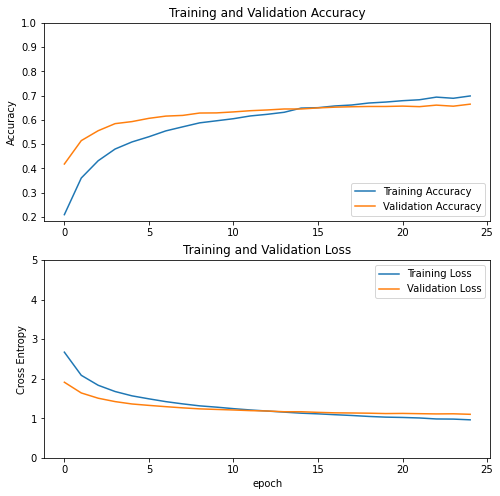

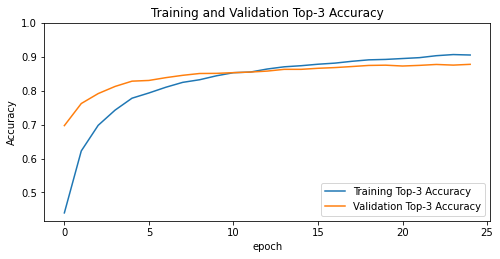

In [26]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

topk = history.history['sparse_top_k_categorical_accuracy']
val_topk = history.history['val_sparse_top_k_categorical_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(topk, label='Training Top-3 Accuracy')
plt.plot(val_topk, label='Validation Top-3 Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('epoch')
plt.title('Training and Validation Top-3 Accuracy')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 170

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])

In [73]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [30]:
len(model.trainable_variables)

6

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [31]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs
checkpoint_path = 'D:/Jen/Documents/Dissertation/Checkpoints/Split_40'
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history_fine = model.fit(train_dataset,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=validation_dataset, 
                    callbacks=[es_callback, cp_callback])

Epoch 25/40
385/385 [==============================] - 1379s 4s/step - loss: 0.9309 - sparse_categorical_accuracy: 0.7077 - sparse_top_k_categorical_accuracy: 0.9123 - val_loss: 1.0859 - val_sparse_categorical_accuracy: 0.6678 - val_sparse_top_k_categorical_accuracy: 0.8803

Epoch 00025: saving model to D:/Jen/Documents/Dissertation/Checkpoints\Split_40
Epoch 26/40
385/385 [==============================] - 1414s 4s/step - loss: 0.9007 - sparse_categorical_accuracy: 0.7224 - sparse_top_k_categorical_accuracy: 0.9231 - val_loss: 1.0810 - val_sparse_categorical_accuracy: 0.6684 - val_sparse_top_k_categorical_accuracy: 0.8797

Epoch 00026: saving model to D:/Jen/Documents/Dissertation/Checkpoints\Split_40
Epoch 27/40
385/385 [==============================] - 1497s 4s/step - loss: 0.8908 - sparse_categorical_accuracy: 0.7186 - sparse_top_k_categorical_accuracy: 0.9198 - val_loss: 1.0683 - val_sparse_categorical_accuracy: 0.6711 - val_sparse_top_k_categorical_accuracy: 0.8827

Epoch 00027:

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [78]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

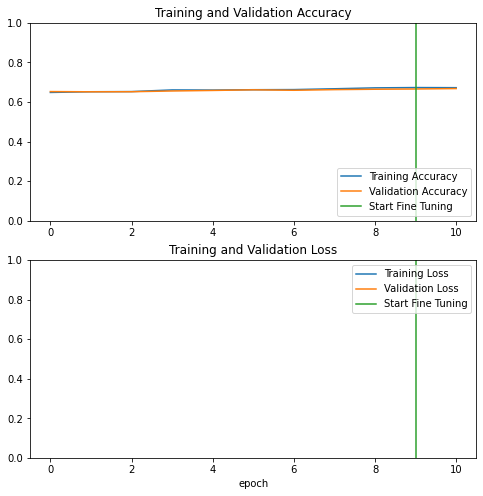

In [80]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [32]:
loss, accuracy, topk = model.evaluate(test_dataset)
print('Test accuracy :', accuracy * 100)
print('Top 3 accuracy :', topk * 100)

163/163 [==============================] - 420s 3s/step - loss: 1.0245 - sparse_categorical_accuracy: 0.6921 - sparse_top_k_categorical_accuracy: 0.8846
Test accuracy : 69.2101240158081
Top 3 accuracy : 88.45859169960022


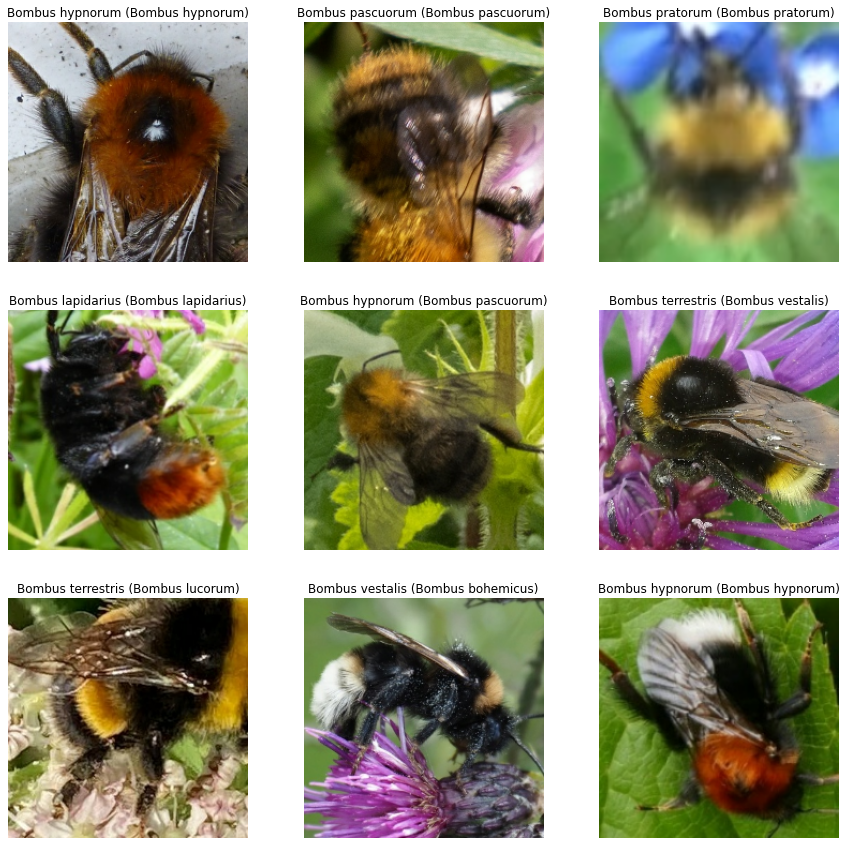

In [56]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

top_k = tf.math.top_k(
    predictions, k=3, sorted=True, name=None
)

predicted_indices = tf.argmax(predictions, 1)
predicted_class = tf.gather(class_names, predicted_indices)

#print('Predictions:\n', top_k[1].numpy())
#print('Labels:\n', label_batch)
#print(tf.gather(class_names, label_batch)[:9])


plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_indices[i]] + " (" + class_names[label_batch[i]] + ")")
  plt.axis("off")

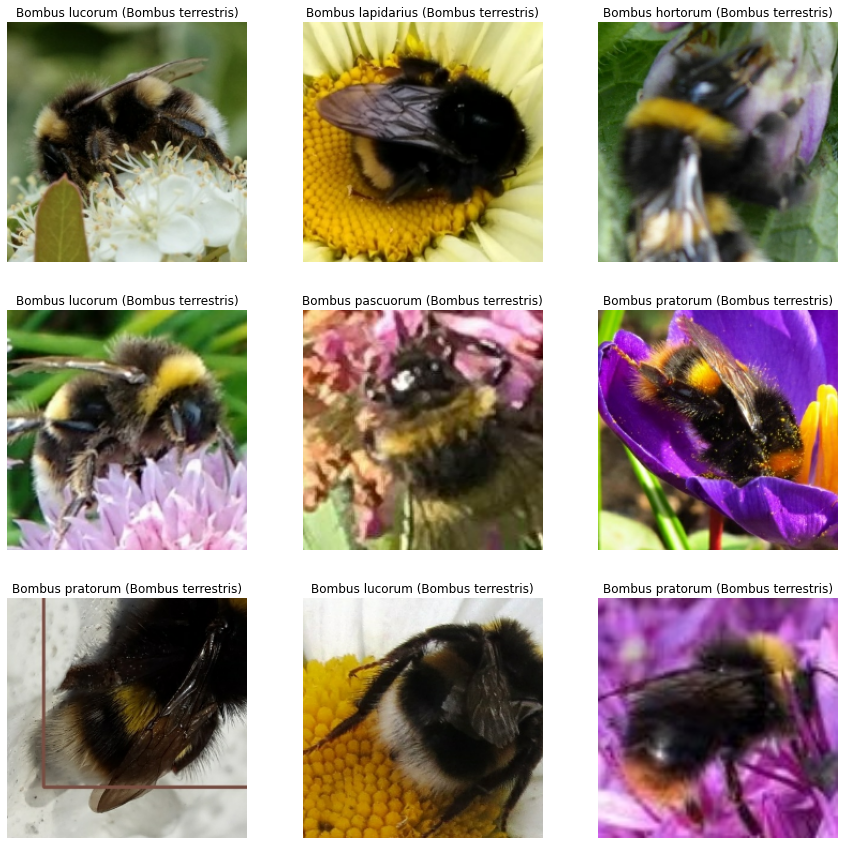

In [55]:
i = 0
plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(tf.data.experimental.cardinality(test_dataset)):
    if i < 9:
        pred = model.predict(images)
        index_values = tf.argmax(pred, 1)
        for j in range(len(labels)):
            if i < 9 and index_values[j] != 17 and labels[j] == 17:
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[j].numpy().astype("uint8"))
                plt.title(class_names[index_values[j]] + " (" + class_names[labels[j]] + ")")
                plt.axis("off")
                i += 1

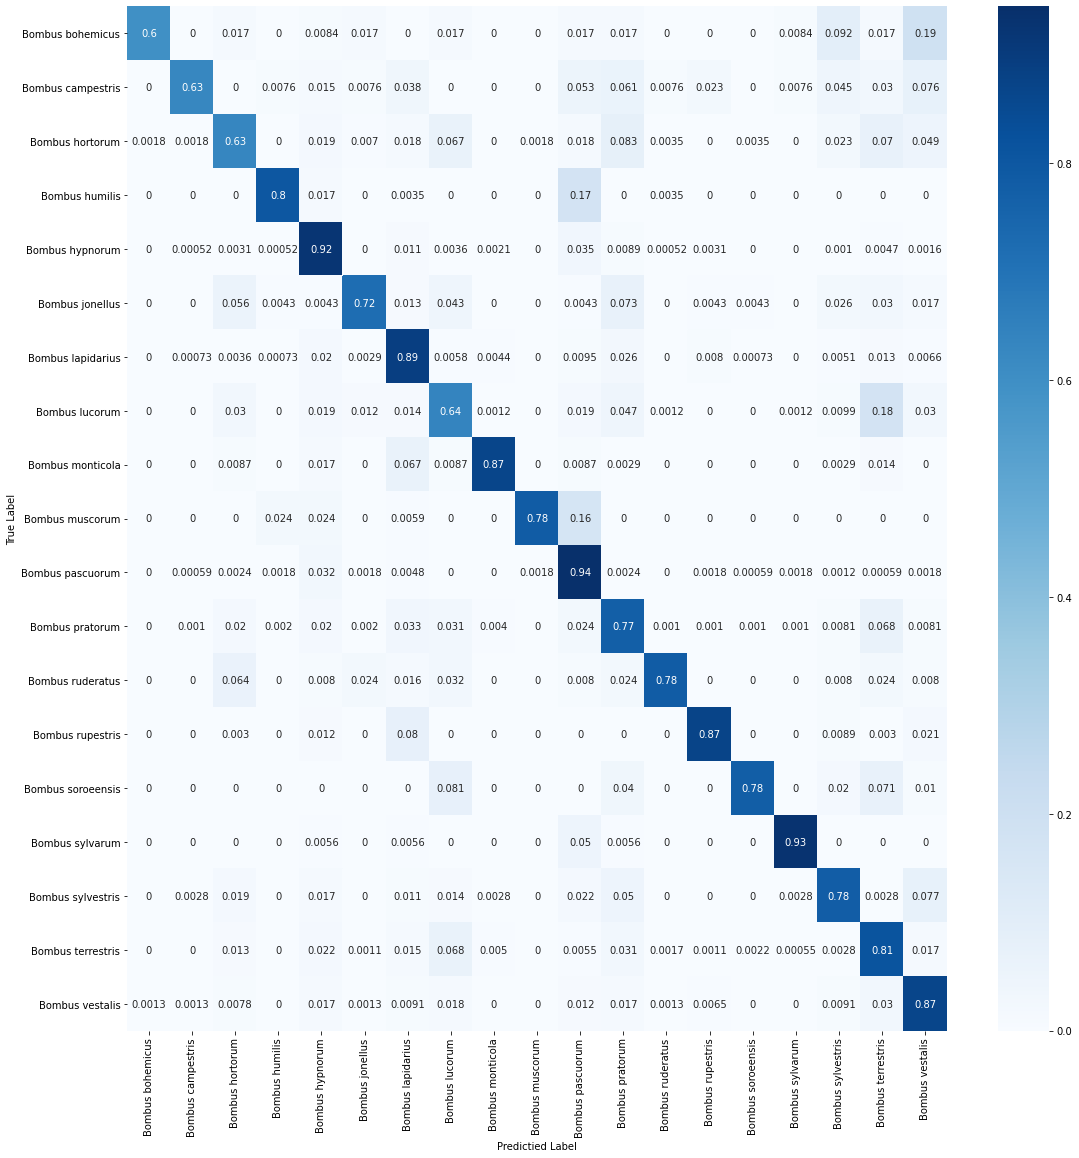

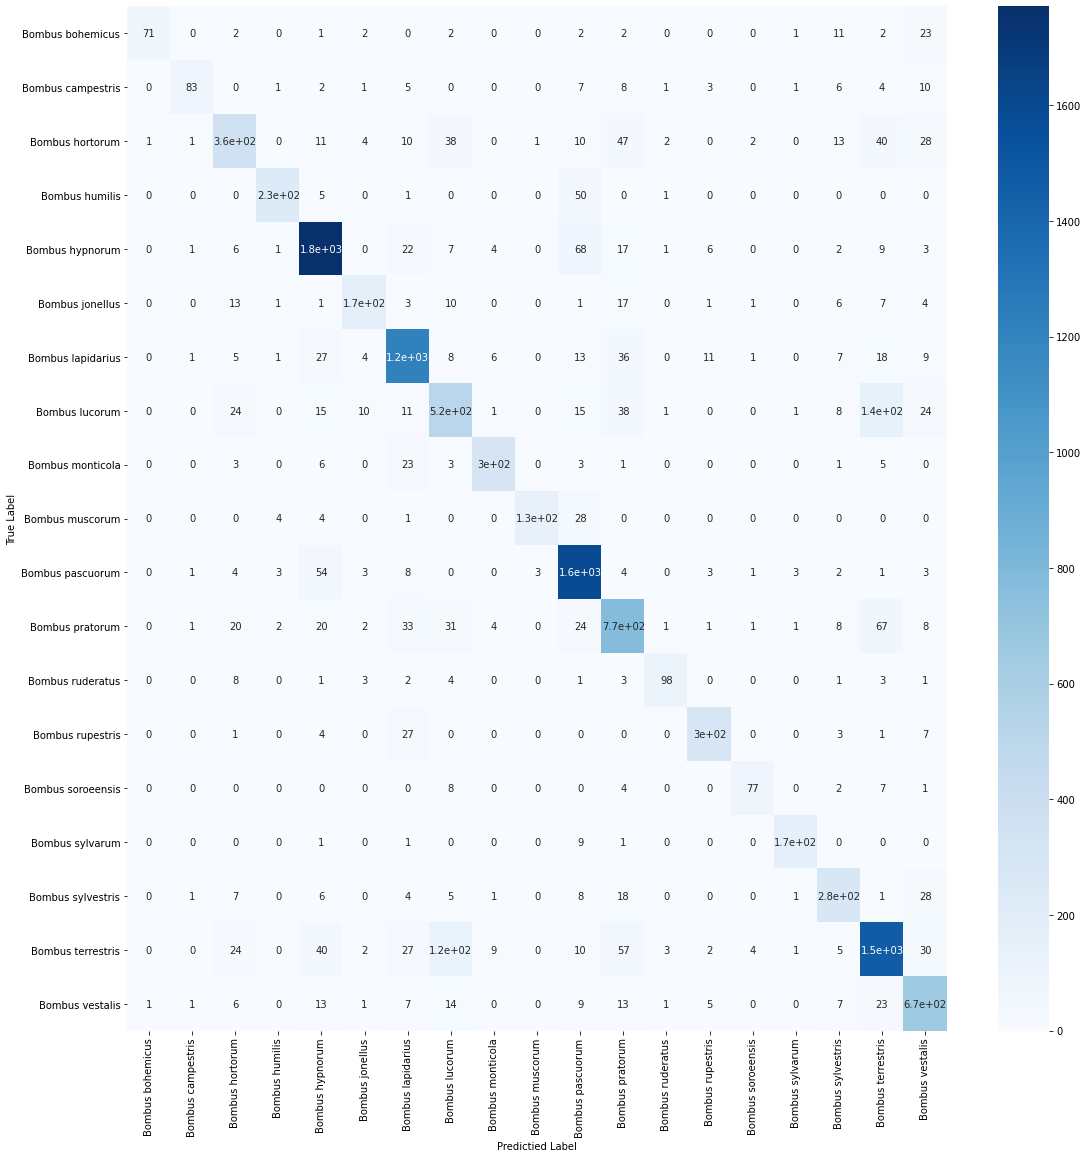

In [34]:
cm = [[0 for _ in range(19)] for _ in range(19)]
for images, labels in train_dataset.take(tf.data.experimental.cardinality(test_dataset)):
    pred = model.predict(images)
    index_values = tf.argmax(pred, 1)
    conf = tf.math.confusion_matrix(labels, index_values, num_classes=19)
    cm = np.add(conf.numpy(), cm)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
figure = plt.figure(figsize=(16, 16))
sns.heatmap(cm_norm, annot=True,cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predictied Label')
plt.show()
figure = plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predictied Label')
plt.show()


In [35]:
model.save('D:/Jen/Documents/Dissertation/Models/Split_40_epochs')

INFO:tensorflow:Assets written to: D:/Jen/Documents/Dissertation/Models/Split_40_epochs\assets


In [5]:
new_model = tf.keras.models.load_model('D:/Jen/Documents/Dissertation/Models/Split_40_epochs')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                40980 

In [10]:
new_loss, new_acc, new_topk = new_model.evaluate(test_dataset)
print('Restored model, accuracy: {:5.2f}%'.format(100 * new_acc))

163/163 [==============================] - 342s 2s/step - loss: 1.0202 - sparse_categorical_accuracy: 0.6931 - sparse_top_k_categorical_accuracy: 0.8859
Restored model, accuracy: 69.31%


In [33]:
taken_dataset = image_dataset_from_directory('D:\Jen\Documents\Dissertation\Bees_Taken',
                                             shuffle=True,
                                             seed=SEED,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
covered_dataset = image_dataset_from_directory('D:\Jen\Documents\Dissertation\Bees_Covered',
                                             shuffle=True,
                                             seed=SEED,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 72 files belonging to 19 classes.
Found 72 files belonging to 19 classes.


In [36]:
taken_loss, taken_accuracy = model.evaluate(taken_dataset)
print('Taken accuracy :', taken_accuracy)
covered_loss, covered_accuracy = model.evaluate(covered_dataset)
print('Covered accuracy :', covered_accuracy)

3/3 [==============================] - 6s 1s/step - loss: 1.2479 - sparse_categorical_accuracy: 0.6250
Taken accuracy : 0.625
3/3 [==============================] - 5s 1s/step - loss: 3.0129 - sparse_categorical_accuracy: 0.0417
Covered accuracy : 0.0416666679084301


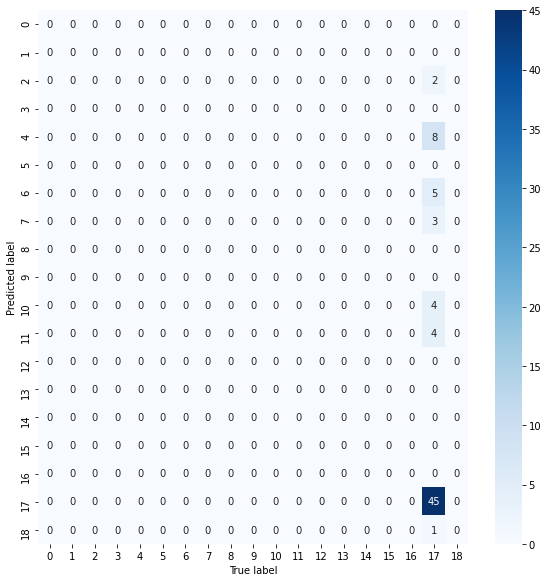

In [37]:
y_pred = model.predict(taken_dataset)
y_index_values = tf.argmax(y_pred, 1)
y_pred_class = tf.gather(class_names, y_index_values)
true_categories = tf.concat([y for x, y in taken_dataset], axis=0)
con_mat = tf.math.confusion_matrix(y_index_values, true_categories)
figure = plt.figure(figsize=(16, 16))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predictied Label')
plt.show()

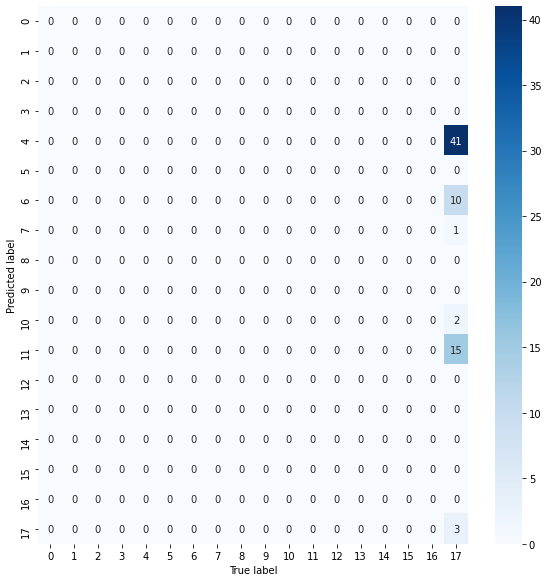

In [38]:
y_pred = model.predict(covered_dataset)
y_index_values = tf.argmax(y_pred, 1)
y_pred_class = tf.gather(class_names, y_index_values)
true_categories = tf.concat([y for x, y in covered_dataset], axis=0)
con_mat = tf.math.confusion_matrix(y_index_values, true_categories, num_classes=19)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [78]:
img_url = "https://kerfdier.nl/wp-content/uploads/2019/08/20190726_krimpenaandenijssel_64-360x360.jpg"
img_path = tf.keras.utils.get_file('Bee3', origin=img_url)

img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=IMG_SIZE
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

prediction = model.predict(img_array)
index = tf.argmax(prediction, 1).numpy()[0]
print("Prediction: {}, with {:.2f} percent confidence."
    .format(class_names[index], 100 * np.max(prediction)))

24576/21968 [=================================] - 0s 1us/step
Prediction: Bombus lapidarius, with 71.15 percent confidence.


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

video_dataset = image_dataset_from_directory('D:\Jen\Documents\Dissertation\Video_Test_Frames_Cropped',
                                             shuffle=False,
                                             seed=SEED,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
new_model = tf.keras.models.load_model('D:/Jen/Documents/Dissertation/Models/Split_40_epochs')

video_pred = new_model.predict(video_dataset)
vid_index_values = tf.argmax(video_pred, 1)
confidences = [0 for i in range(20)]
for i in range(len(vid_index_values)):
    print("Prediction: {}, with {:.2f} percent confidence."
    .format(class_names[vid_index_values[i]], 100 * np.max(video_pred[i])))
    confidences = np.add(video_pred[i], confidences)
#print(confidences)
final_index = np.argmax(confidences)
unique, counts = np.unique(vid_index_values, return_counts=True)
index_count = dict(zip(unique, counts))
print("Prediction: {}, with {:.2f} percent average confidence.".format(class_names[final_index], (100 * confidences[final_index] / index_count[final_index])))

Found 26 files belonging to 1 classes.
Prediction: Bombus jonellus, with 69.51 percent confidence.
Prediction: Bombus jonellus, with 49.59 percent confidence.
Prediction: Bombus terrestris, with 43.64 percent confidence.
Prediction: Bombus terrestris, with 57.56 percent confidence.
Prediction: Bombus terrestris, with 88.04 percent confidence.
Prediction: Bombus lucorum, with 48.73 percent confidence.
Prediction: Bombus terrestris, with 41.65 percent confidence.
Prediction: Bombus terrestris, with 77.64 percent confidence.
Prediction: Bombus terrestris, with 43.29 percent confidence.
Prediction: Bombus lucorum, with 86.63 percent confidence.
Prediction: Bombus lucorum, with 44.47 percent confidence.
Prediction: Bombus monticola, with 66.97 percent confidence.
Prediction: Bombus lucorum, with 69.41 percent confidence.
Prediction: Bombus terrestris, with 50.05 percent confidence.
Prediction: Bombus lucorum, with 69.37 percent confidence.
Prediction: Bombus terrestris, with 54.29 percent c